### Import libraries

In [1]:
import pandas as pd
import numpy as np
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from sklearn import preprocessing
from prophet import Prophet
import warnings
from datetime import timedelta
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import sys
sys.path.append('/Users/i.nuriev/repository/work_space/mmm-tools/mmm_tools')
from media_transformation import *
from model_plotting import *
import statsmodels.api as sm
import matplotlib.dates as mdates

### Metrics

In [2]:
def SMAPE(y_true, y_pred):
    """
    Рассчитывает Symmetric Mean Absolute Percentage Error (SMAPE).
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

### Import data

In [3]:
df = pd.read_excel('initial_data/vkontakte_dau_rf_total.xlsx')

In [4]:
date_start_flight = df[~df.flight_num.eq(0)].dt.min()
date_end_flight = df[~df.flight_num.eq(0)].dt.max()
kpi = 'dau_mln'
df.index = df.dt

In [5]:
df[kpi].iplot()

### Prophet

In [6]:
horizon = df.loc[date_start_flight:].shape[0]
data = df.loc[:pd.to_datetime(date_start_flight) - timedelta(1)].reset_index(drop=True).rename(columns={'dt':'ds',kpi:'y'}).copy()
model = Prophet(seasonality_mode = 'additive',
                changepoint_prior_scale=0.5,
                yearly_seasonality=1,
                weekly_seasonality=True,
                seasonality_prior_scale=1)
model.fit(data)

23:40:17 - cmdstanpy - INFO - Chain [1] start processing
23:40:17 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
future = model.make_future_dataframe(periods=horizon, freq='D')
future = pd.concat([future,data.drop(columns=['ds','y'])],axis=1)

forecast = model.predict(future)
forecast.index = forecast.ds

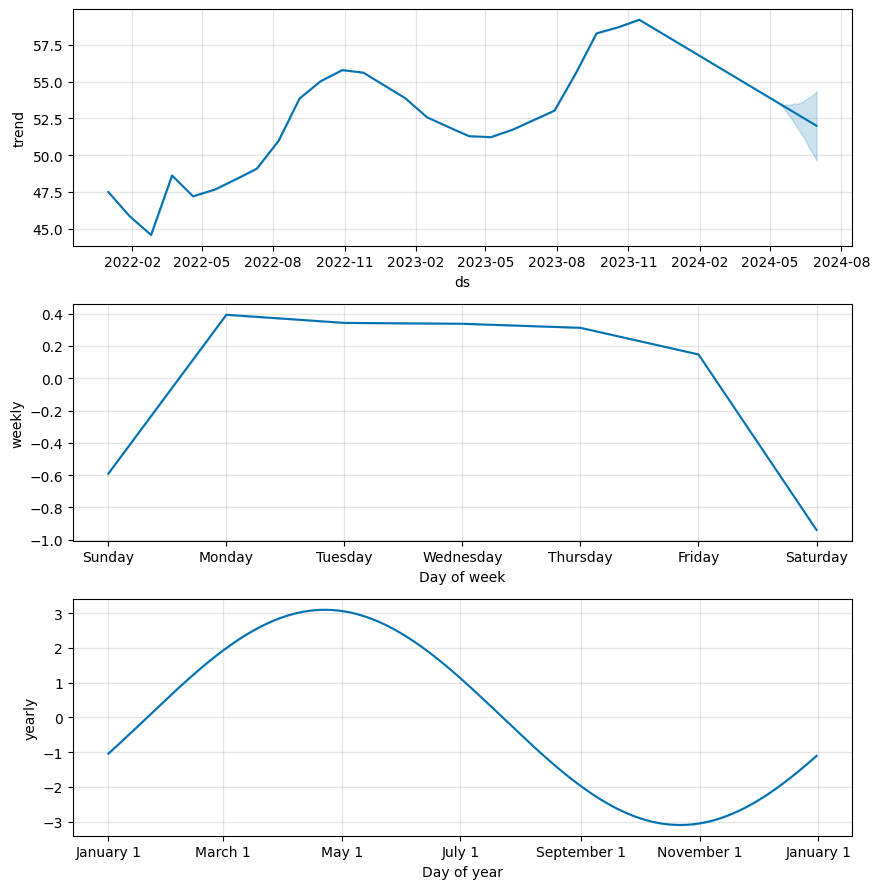

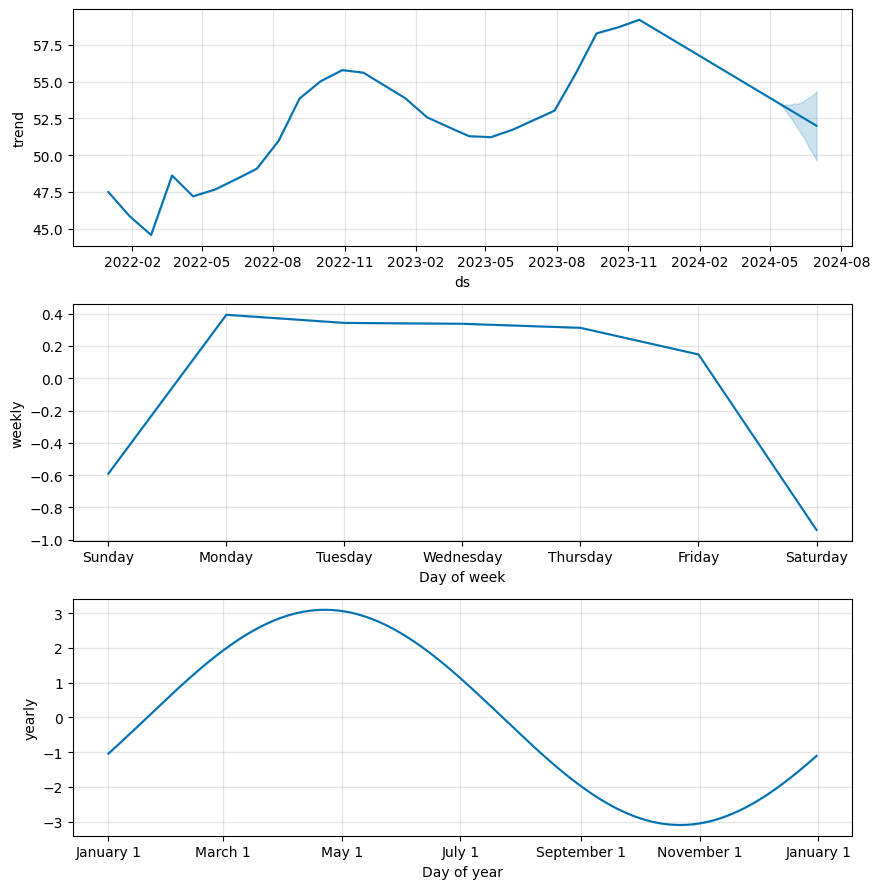

In [8]:
model.plot_components(forecast)

#### Impact

In [9]:
pred_wo_flight = forecast[(forecast.index>=date_start_flight)&(forecast.index<=date_end_flight)]['yhat']
y_true_flight = df[(df.index>=date_start_flight)&(df.index<=date_end_flight)][kpi]

In [10]:
impact_causal = round(np.mean((y_true_flight-pred_wo_flight)/y_true_flight*100),3)

In [11]:
pred_lw = forecast['yhat_lower'].loc[date_start_flight:date_end_flight].values
pred = forecast['yhat'].loc[date_start_flight:date_end_flight].values
pred_up = forecast['yhat_upper'].loc[date_start_flight:date_end_flight].values

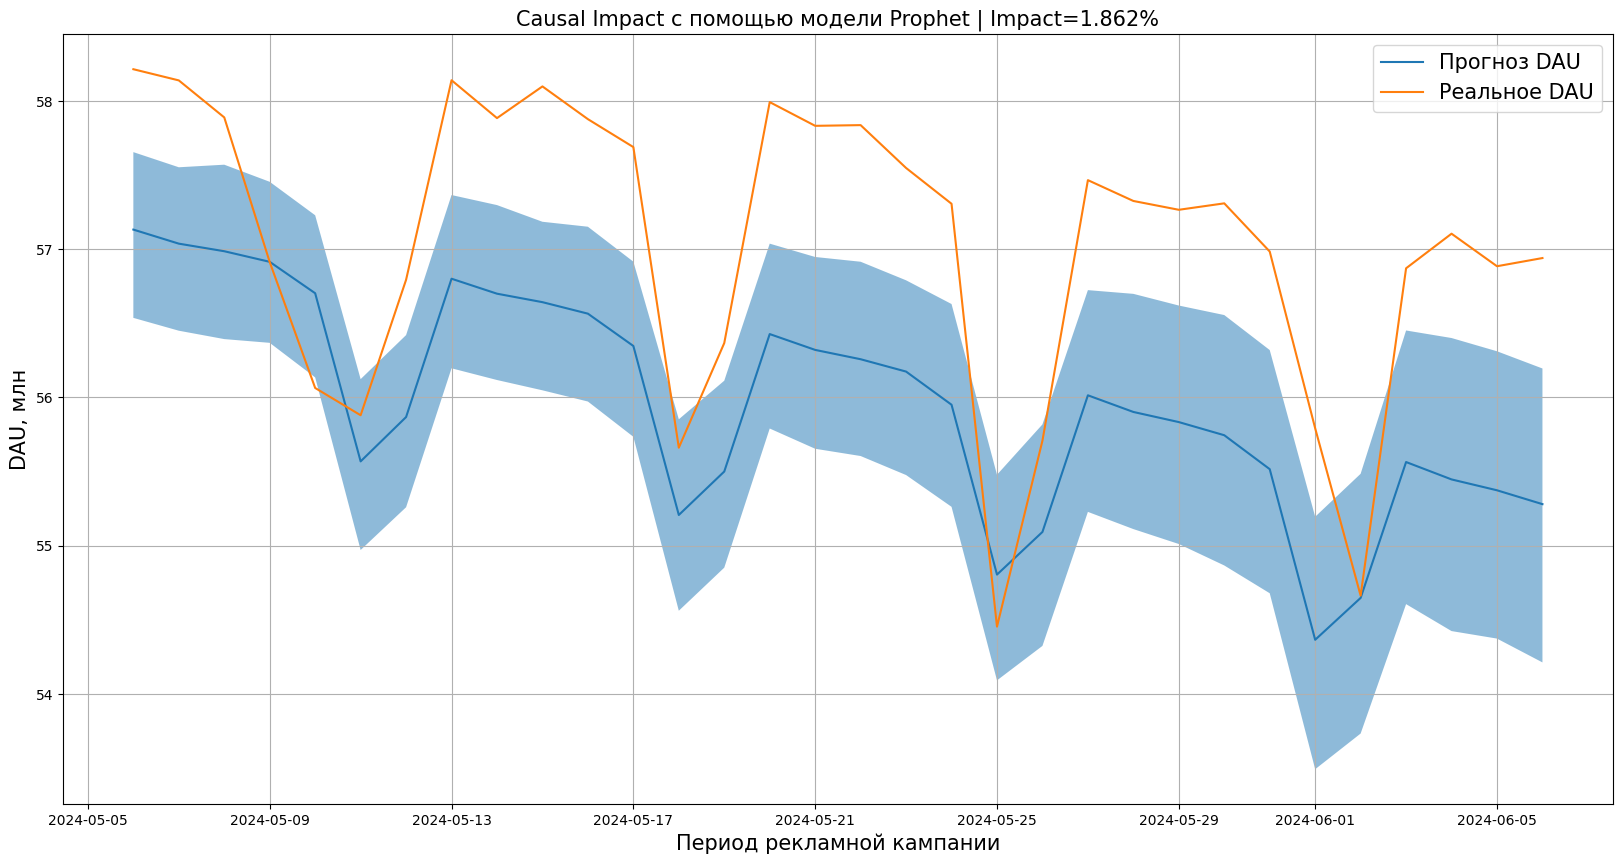

In [12]:
plt.figure(figsize=(20,10))
plt.plot(pred_wo_flight)
plt.plot(y_true_flight)
plt.legend(['Прогноз DAU','Реальное DAU'],fontsize=15)
plt.grid(True)
plt.title(f'Causal Impact с помощью модели Prophet | Impact={impact_causal}%',fontsize=15)
plt.fill_between(pred_wo_flight.index, pred_lw,pred_up, alpha=0.5,
                label = 'Доверительный интервал')
plt.xlabel('Период рекламной кампании',fontsize=15)
plt.ylabel('DAU, млн',fontsize=15)
plt.show()

In [13]:
smape_prophet = SMAPE(y_true_flight, pred_wo_flight)

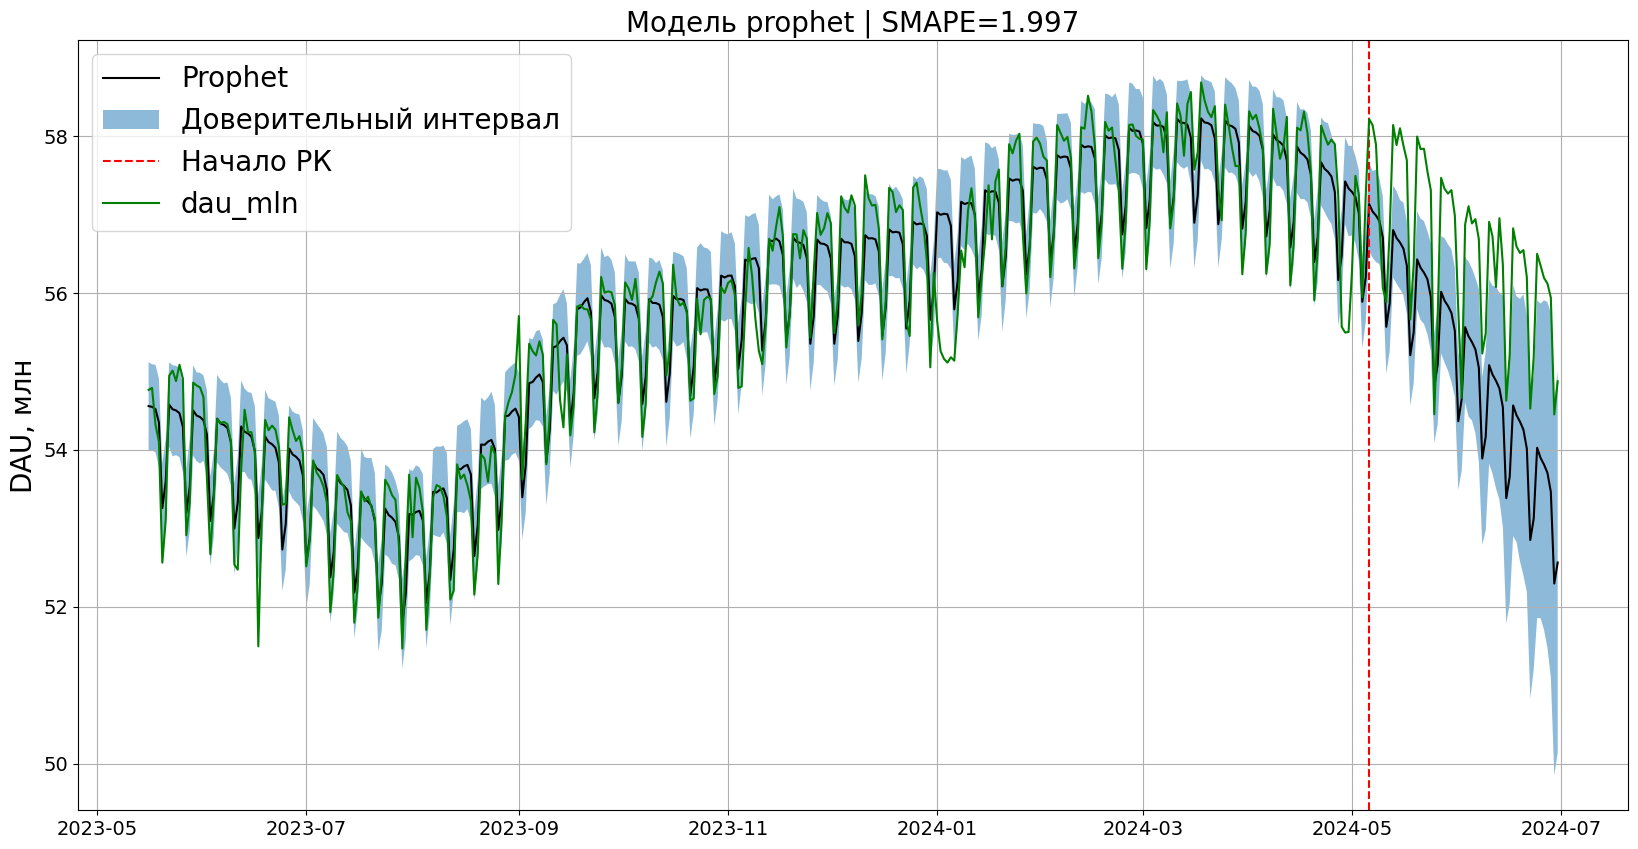

In [14]:
pred_lw = forecast['yhat_lower'].iloc[500:].values
pred = forecast['yhat'].iloc[500:].values
pred_up = forecast['yhat_upper'].iloc[500:].values
date = pd.to_datetime(forecast.ds.iloc[500:].values)
plt.figure(figsize=(20,10))
# plt.plot(date, pred_up, label = 'Верхняя граница ДИ')
plt.plot(date,pred , label = 'Prophet',color='black')
# plt.plot(date, pred_lw, color='blue',label = 'Нижняя граница ДИ')
plt.fill_between(date, pred_lw,pred_up, alpha=0.5,
                label = 'Доверительный интервал')
plt.axvline(x=date_start_flight, color='red', linestyle='--',label='Начало РК')
plt.plot(df.index[500:], df[kpi].iloc[500:],label = kpi,color='green')
plt.ylabel('DAU, млн',fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title(f'Модель prophet | SMAPE={round(smape_prophet,3)}',fontsize=20)
plt.legend(fontsize=20)
plt.grid(True)

In [15]:
results = pd.concat([y_true_flight,pred_wo_flight],axis=1).reset_index().rename(columns = {'yhat':'dau_predict','index':'date'})

In [16]:
results['difference'] = results.dau_mln - results.dau_predict
results.to_excel('results/causal_impact_vkontakte.xlsx')

### OLS

#### Import media-investments

In [17]:
df_media = pd.read_excel('initial_data/media_investments_data_INTERNAL.xlsx',sheet_name = 'PR_VKONTAKTE')
# Checking data quality, fixing bugs
df_media.columns = df_media.loc[1].values
df_media = df_media[3:].reset_index(drop=True)
df_media['date'] = pd.to_datetime(df_media['date'])
df_media.set_index(['date'], inplace=True)
df_media.fillna(0,inplace=True)

#### Definition of media factors

In [18]:
media_factors = [
    'tv_nat_ots_ta_14_44',
    'ooh_ots_total',
    'media_facades_ots_total',
    'metro_mcс_ots_total',
    'universities_ots_total',
    'airports_ots_total',
    'molls_ots_total',
    'digital_media_total_ots_total',
    'bloggers_ots_total'    
]

#### Seasonality and trend from Prophet

23:40:18 - cmdstanpy - INFO - Chain [1] start processing
23:40:19 - cmdstanpy - INFO - Chain [1] done processing


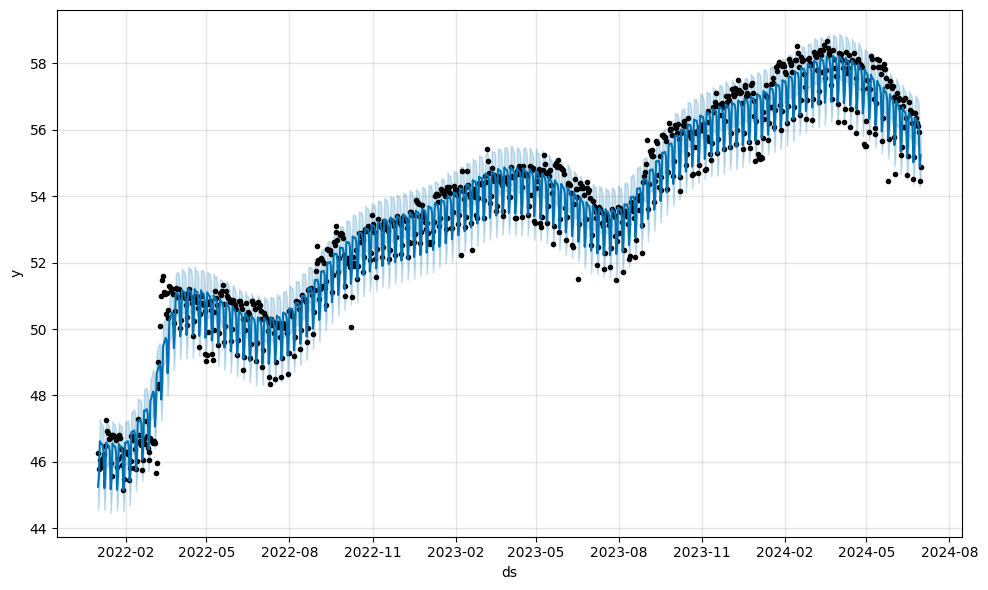

In [19]:
data = df.reset_index(drop=True).rename(columns={'dt':'ds',kpi:'y'}).copy()
model = Prophet(growth='linear',
                seasonality_mode='additive', 
                weekly_seasonality=True, 
                yearly_seasonality=2, # 2 гармоники 
                seasonality_prior_scale=30)
model.fit(data)

future = model.make_future_dataframe(periods=0)

# future['cap'] = trend(horizont)

forecast = model.predict(future)

# Визуализация результатов
fig = model.plot(forecast)

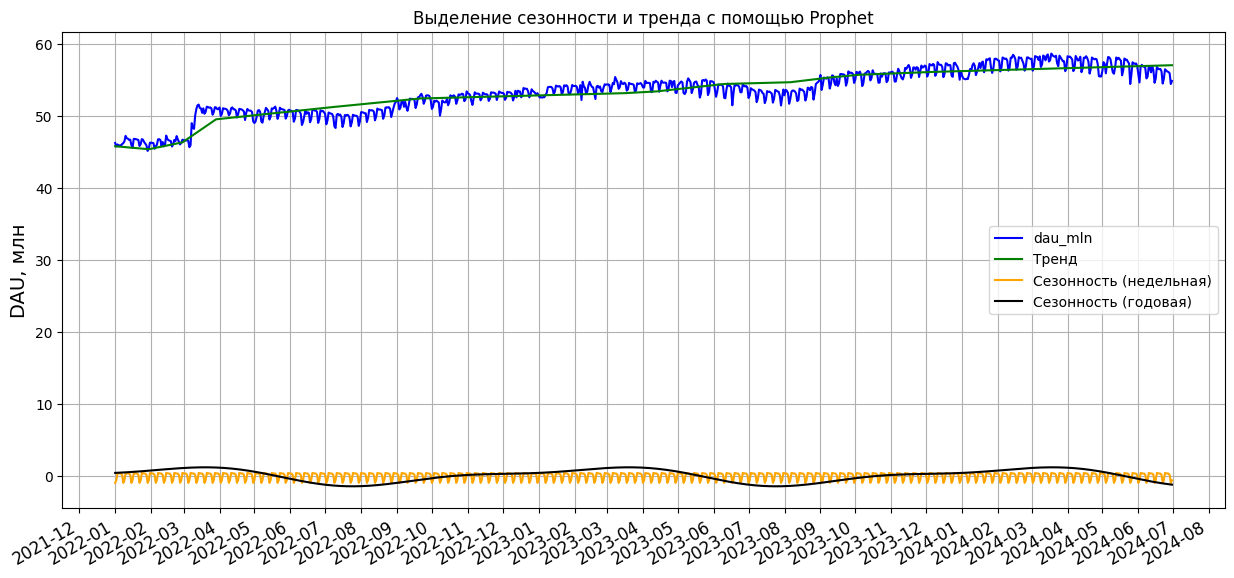

In [20]:
# Визуализация результатов
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(data['ds'], data['y'], label=kpi, color='blue')
ax.plot(data['ds'], forecast['trend'], label='Тренд', color='green')
ax.plot(data['ds'], forecast['weekly'], label='Сезонность (недельная)', color='orange')
ax.plot(data['ds'], forecast['yearly'], label='Сезонность (годовая)', color='black')
# ax.plot(data['ds'], forecast['holiday'], label='праздники', color='red')
plt.legend()
plt.grid(True)
plt.title('Выделение сезонности и тренда с помощью Prophet')
plt.xticks(fontsize=12)
plt.ylabel('DAU, млн',fontsize=14)
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.show()

In [21]:
forecast.index = df.index
df['seasonality_weekly_dau'] = forecast['weekly']
df['seasonality_yearly_dau'] = forecast['yearly']
df['trend_prophet_dau'] = forecast['trend']

non_media_factors = ['seasonality_weekly_dau','seasonality_yearly_dau','trend_prophet_dau']

In [22]:
df_for_scaling = df_media.merge(df[non_media_factors], how='left',right_index=True,left_index=True).fillna(0)

#### Scaling of media factors

In [23]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(df_for_scaling[media_factors + non_media_factors])
df_scaled = scaler.transform(df_for_scaling[media_factors + non_media_factors])
df_scaled = pd.DataFrame(
    data=df_scaled,
    index=df_for_scaling.index, 
    columns=media_factors + non_media_factors
)

df_scaled_ = df_scaled.merge(df[kpi], how='left',right_index=True,left_index=True).fillna(0)

#### Preprocessing of outdoor advertising

##### Geo data

In [24]:
# гео-данные
df_cw = pd.read_excel('initial_data/MS CW geo apps total custom daily.xlsx', skiprows=range(7))
df_cw.rename(columns = {'Дата':'date'},inplace=True)
df_cw['date'] = pd.to_datetime(df_cw['date']) 
df_cw_agg = df_cw[(~df_cw['Медиа'].isin(['Total Internet'])) & 
                  (df_cw['ЦА'] == '14-54') &
                  (df_cw['Гео'] == 'Россия 0+') ].reset_index(drop=True)

df_cw_agg['total_internet'] = df_cw.loc[(df_cw['Медиа'].eq('Total Internet')) & 
                                  (df_cw['Гео'] == 'Россия 0+') &
                                  (df_cw['ЦА'] == '14-54'),['Охват']].reset_index(drop=True)
df_cw_agg['share_geo'] = df_cw_agg['Охват'] / df_cw_agg['total_internet']
df_cw_agg.index = df_cw_agg.date

##### Outdoor advertising transformation

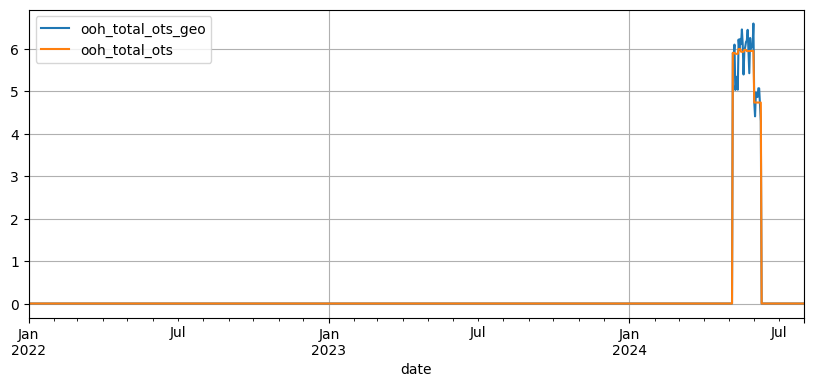

In [25]:
df_scaled = df_scaled_.merge(df_cw_agg[['total_internet','share_geo']],how='left', right_index=True,left_index=True)
share_geo = df_scaled['share_geo']

df_scaled['ooh_total_ots'] = df_scaled[[ 'ooh_ots_total',
                                        'media_facades_ots_total',
                                        'metro_mcс_ots_total',
                                        'universities_ots_total',
                                        'airports_ots_total',
                                        'molls_ots_total'
                                       ]].sum(axis=1)
ooh = df_scaled['ooh_total_ots']
val = ooh*share_geo
val.fillna(0,inplace=True)
df_scaled['ooh_total_ots_geo'] = val/sum(val) * ooh.sum()
# график
plt.figure(figsize=(10,4))
df_scaled['ooh_total_ots_geo'].plot()
df_scaled['ooh_total_ots'].plot()
plt.grid(True)
plt.legend()
plt.show()

#### Media transformations

In [26]:
model_factors = [
        'tv_nat_ots_ta_14_44',
        'ooh_total_ots_geo',
        'digital_media_total_ots_total',
        'bloggers_ots_total'
]

In [27]:
media_config = 'config/media_params_initial_dau.xlsx'

df_params = upload_media_params_file(media_config)
init_params = prepare_media_params_init(df_params)
params_init_dict = create_media_params_dict(params=init_params['params'], media_factors=init_params['media'])

In [28]:
opt_params = optimize_media_params_penalty(y=df_scaled[kpi],
                      df=df_scaled[model_factors],
                      media_factors=init_params['media'],
                      params_init=init_params['params'],
                      bounds_init=init_params['bounds'],
                      tol=0.00001,
                      epsilon_step=0.1
                     )

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10
  Positive dir derivative in projection 
  Using the backtracking step 
  Positive dir derivative in projection 
  Using the backtracking step 

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     34     68     50     4     9   1.227D+00   3.774D+04

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [29]:
optimal_params = create_media_params_dict(params=opt_params, 
                         media_factors=init_params['media'])

In [30]:
df_transformed = transform_media_data(df_scaled, optimal_params, model_factors)
df_transformed = df_transformed.merge(df_scaled[non_media_factors + [kpi]], how = 'left', right_index=True,left_index=True)

#### Plot transformed data

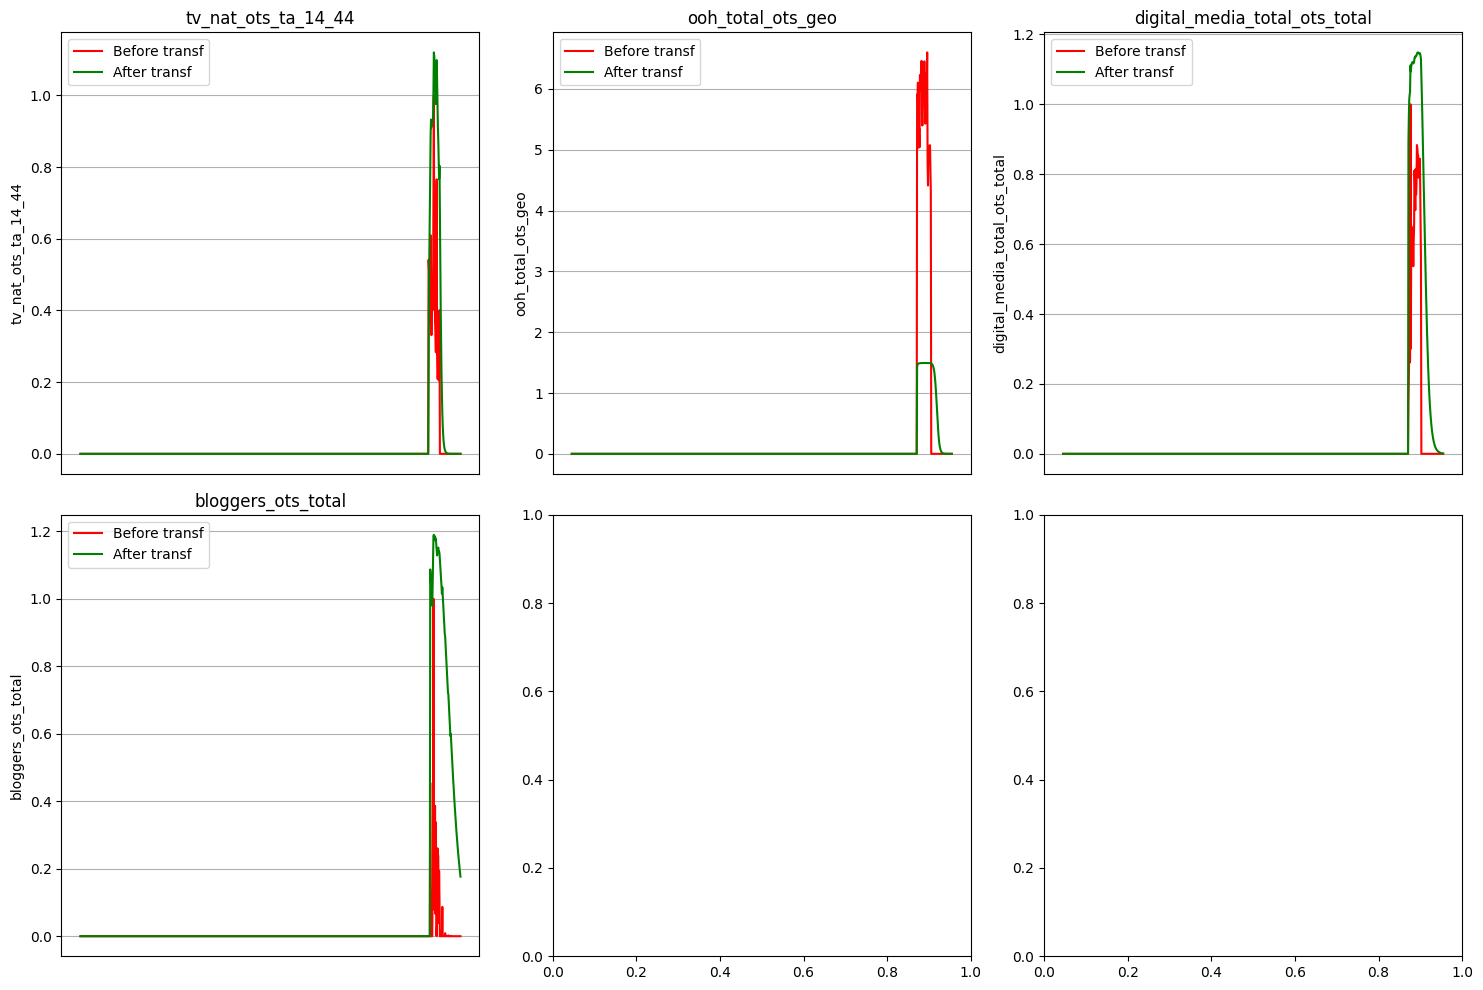

In [31]:
plot_transformed_data(df_scaled, df_transformed, optimal_params.keys()) 

#### Media aggregation

In [32]:
df_transformed['media_total_online_ots'] = df_transformed[['tv_nat_ots_ta_14_44','ooh_total_ots_geo']].sum(axis=1)
df_transformed['media_total_offline_ots'] = df_transformed[['digital_media_total_ots_total','bloggers_ots_total']].sum(axis=1)
df_transformed['media_total_ots']  = df_transformed['media_total_online_ots'] + df_transformed['media_total_offline_ots']

#### Model

In [33]:
model_factors = ['media_total_ots'] + non_media_factors

In [34]:
date_end_dau = df.dt.max()
y = df_transformed[kpi].loc[:date_end_dau]
X = df_transformed[model_factors].loc[:date_end_dau]

lag_value=1
model=sm.OLS(y,X,missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
print(model.summary())

print(f'SMAPE: {round(SMAPE(y, model.fittedvalues),2)} %')

                                 OLS Regression Results                                
Dep. Variable:                dau_mln   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.782e+06
Date:                Thu, 08 Aug 2024   Prob (F-statistic):                        0.00
Time:                        23:40:34   Log-Likelihood:                         -702.55
No. Observations:                 912   AIC:                                      1413.
Df Residuals:                     908   BIC:                                      1432.
Df Model:                           4                                                  
Covariance Type:                  HAC                                                  
                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

##### Model decomposition

In [35]:
plot_decomposition(df_transformed.loc[:date_end_dau],model,kpi_name=kpi)

##### Comparison of actual values with model values

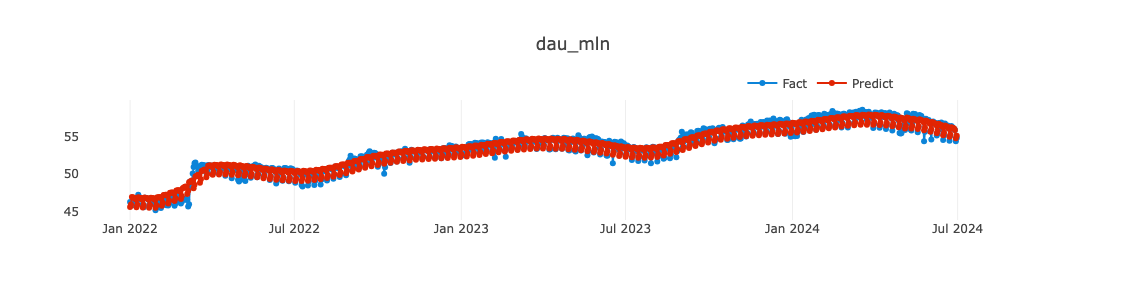

In [36]:
prediction = model.get_prediction(X)
prediction.summary_frame()[['mean','mean_ci_lower', 'mean_ci_upper']].to_clipboard()
prediction.summary_frame()[['mean','mean_ci_lower', 'mean_ci_upper']].to_clipboard()
fig=make_subplots(specs=[[{"secondary_y": True}]])
fig=fig.add_trace(go.Scatter(x=y.index,y=y,mode='lines+markers',name='Fact',marker_color='#0c84d8'),secondary_y=False,)
fig=fig.add_trace(go.Scatter(x=model.fittedvalues.index,y=model.fittedvalues,mode='lines+markers',name='Predict',marker_color='#e12503'),secondary_y=False,)
fig.update_layout(barmode='stack',title=kpi,template='ygridoff', width=800,height=300)
plt.show()

fig.update_layout(legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=0.83))

#### Media impact

In [37]:
df_flowchart = pd.read_excel('initial_data/media_budget.xlsx', index_col=0).fillna(0.)
upd_params = pd.Series({
                        'tv_nat_ots_ta_14_44':model.params.get('media_total_ots'),
                        'ooh_total_ots_geo':model.params.get('media_total_ots'),
                        'digital_media_total_ots_total':model.params.get('media_total_ots'),
                        'bloggers_ots_total':model.params.get('media_total_ots'),
                        'seasonality_weekly_dau':model.params.get('seasonality_weekly_dau'),
                        'seasonality_yearly_dau':model.params.get('seasonality_yearly_dau'),
                        'trend_prophet_dau':model.params.get('trend_prophet_dau'),
                       })

##### Media spends

In [38]:
tv_spends = df_media['tv_nat_spends'].sum()
ooh_spends = df_media[['ooh_spends', 'media_facades_spends',
                       'metro_mcс_spends','universities_spends',
                       'airports_spends','molls_spends']].sum(axis=1).sum()
digital_media_spends = df_media['digital_media_total_spends'].sum()
bloggers_spends = df_media['bloggers_spends'].sum()
df_flowchart['budget'] = [tv_spends, ooh_spends, digital_media_spends, bloggers_spends]

In [39]:
pd.set_option('display.float_format', '{:.3f}'.format)
media_impacts = media_impact(df_transformed, 
             df_flow_init=df_flowchart, 
             media_factors=df_flowchart.index,
             other_factors=non_media_factors,
             kpi='dau_mln', 
             model_params=upd_params, avg_over_period=True)
media_impacts.to_excel('results/vkontakte_media_impact.xlsx')
media_impacts

Сценарий без РК: 56.76339


,date_start,date_end,budget,impact,kpi,impact_%,add_impact_%,CPA
tv_nat_ots_ta_14_44,2024-05-06,2024-06-06,158140987.000,0.046,57.028,0.081,0.081,107017667.999
ooh_total_ots_geo,2024-05-06,2024-06-06,122003552.594,0.098,57.028,0.171,0.172,38991083.532
digital_media_total_ots_total,2024-05-06,2024-06-06,77516.000,0.073,57.028,0.128,0.128,33245.338
bloggers_ots_total,2024-05-06,2024-06-06,10227.000,0.048,57.028,0.085,0.085,6628.322
media_total,2024-05-06,2024-06-06,280232282.594,0.265,57.028,0.465,0.467,33041270.915
seasonality_weekly_dau,NaT,NaT,NaN,0.990,57.028,1.736,1.744,NaN
seasonality_yearly_dau,NaT,NaT,NaN,1.333,57.028,2.338,2.349,NaN
trend_prophet_dau,NaT,NaT,NaN,54.371,57.028,95.340,95.785,NaN
